<a href="https://colab.research.google.com/github/nooYeaT/NLP/blob/main/%EB%84%A4%EC%9D%B4%EB%B2%84%EC%98%81%ED%99%94%EB%A6%AC%EB%B7%B0%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [12]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7effdda50f10>)

In [5]:
train_data=pd.read_table('ratings_train.txt')
test_data=pd.read_table('ratings_test.txt')

In [6]:
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [7]:
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [8]:
train_data.drop_duplicates(subset=['document'], inplace=True)

In [9]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


<Axes: xlabel='label'>

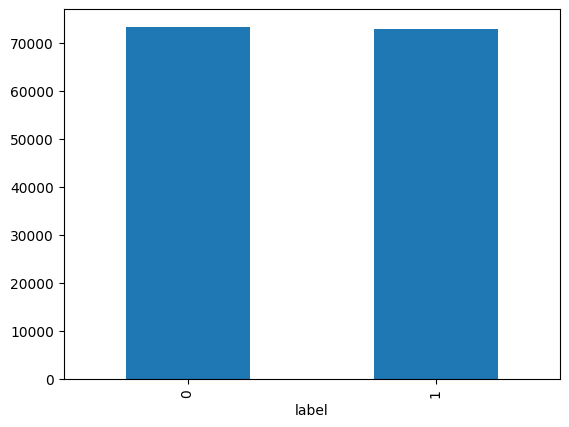

In [10]:
train_data['label'].value_counts().plot(kind='bar')

In [11]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72841


In [13]:
print(train_data.isnull().values.any())

True


In [14]:
train_data.isnull().sum()

,0
id,0
document,1
label,0


In [15]:
train_data=train_data.dropna(how='any')
train_data.isnull().sum()

,0
id,0
document,0
label,0


In [16]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [17]:
train_data['document'] = train_data['document'].str.replace('^ +', "", regex=True) # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


<ipython-input-17-59a2387a36e3>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['document'].replace('', np.nan, inplace=True)


In [18]:
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [19]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145393


In [20]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True) # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "", regex=True) # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


<ipython-input-20-59211301370a>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경


In [21]:
stopwords=['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

okt=Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem=True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [22]:
X_train=[]
for sentence in tqdm(train_data['document']):
  tokenized_sentence=okt.morphs(sentence, stem=True)
  stopwords_removed_sentence=[word for word in tokenized_sentence if word not in stopwords]
  X_train.append(stopwords_removed_sentence)

100%|██████████| 145393/145393 [06:01<00:00, 402.24it/s]


In [23]:
X_train[:3]

[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]

In [24]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 48852/48852 [01:57<00:00, 415.64it/s]


In [ ]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
threshold=3
total_cnt=len(tokenizer.word_index)
rare_cnt=0
total_freq=0
rare_freq=0

for key, value in tokenizer.word_counts.items():
  total_freq+=value

  if value<threshold:
    rare_cnt+=1
    rare_freq+=value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8715872104872904


In [ ]:
vocab_size=total_cnt-rare_cnt+1
vocab_size

19416

In [ ]:
tokenizer=Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
X_train=tokenizer.texts_to_sequences(X_train)
X_test=tokenizer.texts_to_sequences(X_test)

X_train[:4]

[[50, 454, 16, 260, 659],
 [933, 457, 41, 602, 1, 214, 1449, 24, 961, 675, 19],
 [386, 2444, 2315, 5671, 2, 222, 9],
 [6492, 105, 8118, 218, 56, 4, 26, 3603]]

In [ ]:
y_train=np.array(train_data['label'])
y_test=np.array(test_data['label'])

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]

In [ ]:
X_train=[x for i, x in enumerate(X_train) if i not in set(drop_train)]
y_train=[x for i, x in enumerate(y_train) if i not in set(drop_train)]

In [ ]:
print(len(X_train))
print(len(y_train))

145162
145162


69
10.812485361182679


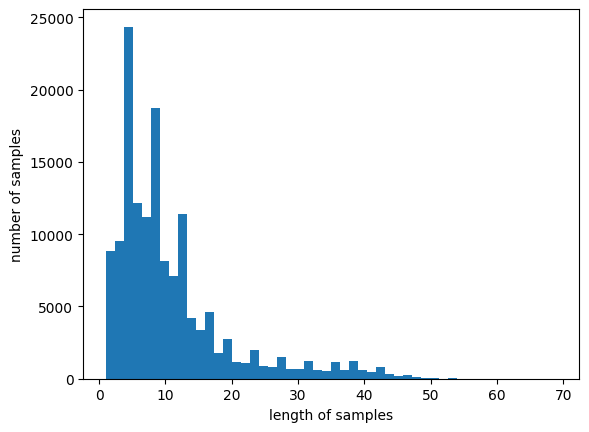

In [ ]:
print(max(len(review) for review in X_train))
print(sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))


In [ ]:
max_len=30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.31944999380003


In [ ]:
X_train=pad_sequences(X_train, maxlen=max_len)
X_test=pad_sequences(X_test, maxlen=max_len)

In [ ]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.keras', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)


Epoch 1/15
1815/1815 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.7586 - loss: 0.4751
Epoch 1: val_acc improved from -inf to 0.83030, saving model to best_model.keras
1815/1815 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - acc: 0.7586 - loss: 0.4751 - val_acc: 0.8303 - val_loss: 0.3756
Epoch 2/15
1812/1815 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.8492 - loss: 0.3476
Epoch 2: val_acc improved from 0.83030 to 0.84297, saving model to best_model.keras
1815/1815 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - acc: 0.8492 - loss: 0.3476 - val_acc: 0.8430 - val_loss: 0.3530
Epoch 3/15
1810/1815 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.8639 - loss: 0.3154
Epoch 3: val_acc improved from 0.84297 to 0.85255, saving model to best_model.keras
1815/1815 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - acc: 0.8639 - loss: 0.3154 - val_acc: 0.8525 - val_loss: 0.3386
Epoch 4/15
1806/1815 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.8764 - loss: 0.2954
Epoch 4: val_acc improved from 0.85255 to 0.85613, saving model to best_model.keras
1815/

In [ ]:
loaded_model=load_model('best_model.keras')
loaded_model.evaluate(X_test, y_test)

1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - acc: 0.8557 - loss: 0.3456


[0.3488772511482239, 0.853639543056488]

In [ ]:
def sentiment_predict(new_sentence):
  new_sentence=re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence=okt.morphs(new_sentence, stem=True)
  new_sentence=[word for word in new_sentence if not word in stopwords]
  encoded=tokenizer.texts_to_sequences([new_sentence])
  pad_new=pad_sequences(encoded, maxlen=max_len)
  score=float(loaded_model.predict(pad_new))
  if score>0.5:
    print('{:.2f}%확률로 긍정 리뷰입니다.\n'.format(score*100))
  else:
    print('{:.2f}%확률로 부정 리뷰입니다.\n'.format((1 - score) * 100))

In [ ]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
85.46%확률로 긍정 리뷰입니다.



<ipython-input-38-1ef8a30f85ef>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score=float(loaded_model.predict(pad_new))


In [ ]:
sentiment_predict('이 영화 핵노잼 ㅠㅠ')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
97.23%확률로 부정 리뷰입니다.



<ipython-input-38-1ef8a30f85ef>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score=float(loaded_model.predict(pad_new))


In [ ]:
sentiment_predict('이딴게 영화냐 ㅉㅉ')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
99.75%확률로 부정 리뷰입니다.



<ipython-input-38-1ef8a30f85ef>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score=float(loaded_model.predict(pad_new))


In [ ]:
sentiment_predict('감독 뭐하는 놈이냐?')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
99.17%확률로 부정 리뷰입니다.



<ipython-input-38-1ef8a30f85ef>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score=float(loaded_model.predict(pad_new))


In [ ]:
sentiment_predict('와 개쩐다 정말 세계관 최강자들의 영화다')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
87.46%확률로 긍정 리뷰입니다.



<ipython-input-38-1ef8a30f85ef>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score=float(loaded_model.predict(pad_new))


CNN 사용

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

embedding_dim = 128
dropout_ratio = (0.5, 0.8)
num_filters = 128
hidden_units = 128

model_input=Input(shape=(max_len, ))
z=Embedding(vocab_size, embedding_dim, input_length=max_len, name='embedding')(model_input)
z=Dropout(dropout_ratio[0])(z)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
conv_blocks = []

for sz in [3, 4, 5]:
    conv = Conv1D(filters = num_filters,
                         kernel_size = sz,
                         padding = "valid",
                         activation = "relu",
                         strides = 1)(z)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)

In [ ]:
z=Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
z=Dropout(dropout_ratio[1])(z)
z=Dense(hidden_units, activation='relu')(z)
model_output=Dense(1, activation='sigmoid')(z)

model=Model(model_input, model_output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('CNN_model.keras', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.2, verbose=2, callbacks=[es, mc])

Epoch 1/10

Epoch 1: val_acc improved from -inf to 0.83984, saving model to CNN_model.keras
1815/1815 - 20s - 11ms/step - acc: 0.7871 - loss: 0.4388 - val_acc: 0.8398 - val_loss: 0.3729
Epoch 2/10

Epoch 2: val_acc improved from 0.83984 to 0.84635, saving model to CNN_model.keras
1815/1815 - 7s - 4ms/step - acc: 0.8522 - loss: 0.3469 - val_acc: 0.8463 - val_loss: 0.3631
Epoch 3/10

Epoch 3: val_acc improved from 0.84635 to 0.84793, saving model to CNN_model.keras
1815/1815 - 6s - 4ms/step - acc: 0.8676 - loss: 0.3143 - val_acc: 0.8479 - val_loss: 0.3537
Epoch 4/10

Epoch 4: val_acc did not improve from 0.84793
1815/1815 - 6s - 3ms/step - acc: 0.8797 - loss: 0.2891 - val_acc: 0.8476 - val_loss: 0.3593
Epoch 5/10

Epoch 5: val_acc did not improve from 0.84793
1815/1815 - 7s - 4ms/step - acc: 0.8891 - loss: 0.2716 - val_acc: 0.8464 - val_loss: 0.3626
Epoch 6/10

Epoch 6: val_acc did not improve from 0.84793
1815/1815 - 11s - 6ms/step - acc: 0.8969 - loss: 0.2528 - val_acc: 0.8431 - val_lo

In [ ]:
loaded_model=load_model('CNN_model.keras')
loaded_model.evaluate(X_test, y_test)

1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - acc: 0.8421 - loss: 0.3594


[0.3623010814189911, 0.8408458232879639]

In [ ]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
88.16%확률로 긍정 리뷰입니다.



<ipython-input-38-1ef8a30f85ef>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score=float(loaded_model.predict(pad_new))


In [ ]:
sentiment_predict('이 영화 핵노잼 ㅠㅠ')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
97.25%확률로 부정 리뷰입니다.



<ipython-input-38-1ef8a30f85ef>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score=float(loaded_model.predict(pad_new))


In [ ]:
sentiment_predict('이딴게 영화냐 ㅉㅉ')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
97.43%확률로 부정 리뷰입니다.



<ipython-input-38-1ef8a30f85ef>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score=float(loaded_model.predict(pad_new))


In [ ]:
sentiment_predict('감독 뭐하는 놈이냐?')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
92.95%확률로 부정 리뷰입니다.



<ipython-input-38-1ef8a30f85ef>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score=float(loaded_model.predict(pad_new))


In [ ]:
sentiment_predict('와 개쩐다 정말 세계관 최강자들의 영화다')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
74.18%확률로 긍정 리뷰입니다.



<ipython-input-38-1ef8a30f85ef>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score=float(loaded_model.predict(pad_new))
